In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Flatten, Dropout

In [2]:
df = pd.read_csv('TeslaInc. ( TSLA ).csv', parse_dates=['Date'], index_col=['Date'])

In [3]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500
2010-07-07,1.093333,1.108667,0.998667,1.053333,1.053333,103825500


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3077 entries, 2010-06-30 to 2022-09-19
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3077 non-null   float64
 1   High       3077 non-null   float64
 2   Low        3077 non-null   float64
 3   Close      3077 non-null   float64
 4   Adj Close  3077 non-null   float64
 5   Volume     3077 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 168.3 KB


In [7]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

In [8]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size, 3])  # Predicting 'Close' price
    return np.array(X), np.array(y)

In [9]:
train_size = int(len(df) * 0.9)
validation_size = int(train_size * 0.05)
test_size = int(train_size * 0.05)

train_data = scaled_data[:train_size]
val_data = scaled_data[train_size:train_size + validation_size]
test_data = scaled_data[train_size + validation_size:train_size + validation_size + test_size]

In [10]:
window_size = 10

X_train, y_train = create_sequences(train_data, window_size)
X_val, y_val = create_sequences(val_data, window_size)
X_test, y_test = create_sequences(test_data, window_size)

In [11]:
input_layer = Input(shape=(window_size, 6))

conv1 = Conv1D(filters=64, kernel_size=2, activation='relu')(input_layer)
conv2 = Conv1D(filters=128, kernel_size=2, activation='relu')(conv1)
flatten = Flatten()(conv2)

lstm = LSTM(64, return_sequences=False)(input_layer)

merged = tf.keras.layers.concatenate([flatten, lstm])

dense1 = Dense(64, activation='relu')(merged)
dropout = Dropout(0.2)(dense1)
output_layer = Dense(1, activation='linear')(dropout)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [12]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/50
87/87 [==============================] - 11s 35ms/step - loss: 0.0302 - mae: 0.0921 - val_loss: 0.3215 - val_mae: 0.4993
Epoch 2/50
87/87 [==============================] - 2s 19ms/step - loss: 0.0108 - mae: 0.0647 - val_loss: 0.0773 - val_mae: 0.1956
Epoch 3/50
87/87 [==============================] - 2s 19ms/step - loss: 0.0098 - mae: 0.0613 - val_loss: 0.3626 - val_mae: 0.5443
Epoch 4/50
87/87 [==============================] - 2s 18ms/step - loss: 0.0097 - mae: 0.0584 - val_loss: 0.0658 - val_mae: 0.1811
Epoch 5/50
87/87 [==============================] - 2s 19ms/step - loss: 0.0108 - mae: 0.0600 - val_loss: 0.2792 - val_mae: 0.4656
Epoch 6/50
87/87 [==============================] - 2s 17ms/step - loss: 0.0088 - mae: 0.0548 - val_loss: 0.1793 - val_mae: 0.3609
Epoch 7/50
87/87 [==============================] - 2s 19ms/step - loss: 0.0082 - mae: 0.0547 - val_loss: 0.1308 - val_mae: 0.2961
Epoch 8/50
87/87 [==============================] - 2s 18ms/step - loss: 0.0096 - 

In [13]:
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

4/4 [==============================] - 0s 10ms/step - loss: 0.1123 - mae: 0.3002
Test Loss: 0.11227964609861374, Test MAE: 0.3002195954322815


In [14]:
predictions = model.predict(X_test)

y_test_actual = scaler.inverse_transform(np.hstack((np.zeros((y_test.shape[0], 5)), y_test.reshape(-1, 1))))[:, -1]
predictions_actual = scaler.inverse_transform(np.hstack((np.zeros((predictions.shape[0], 5)), predictions)))[:, -1]

4/4 [==============================] - 1s 9ms/step


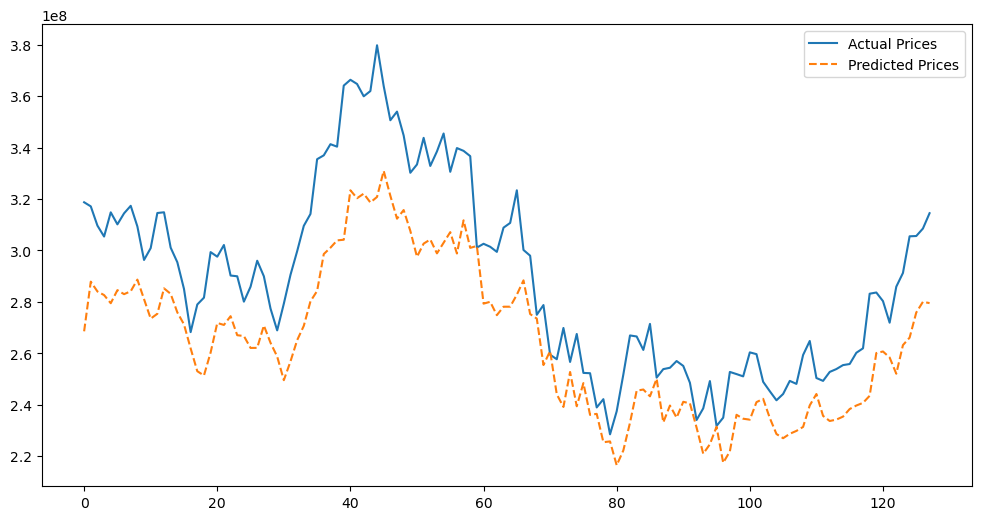

In [15]:
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label="Actual Prices")
plt.plot(predictions_actual, label="Predicted Prices", linestyle="dashed")
plt.legend()
plt.show()